In [12]:
import pandas as pd
import functions
import numpy as np
import sklearn
import scipy
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [6]:
expression = pd.read_csv('../data/interim/mouse_atlas/mouse_atlas_expression.tsv', sep='\t', index_col=0)
samples    = pd.read_csv('../data/interim/mouse_atlas/mouse_atlas_samples.tsv', sep='\t', index_col=0)
samples = samples.rename(columns = {'Platform':'Platform_Category'})
print(expression.shape, samples.shape)

(14222, 1074) (1074, 5)


In [5]:
# calculate platform dependence of each gene 
vp = functions.calculate_platform_dependence(expression, samples)
vp = vp.sort_values(by=['VarFraction'])
%notify -m "The cell has finished running"

<IPython.core.display.Javascript object>

### Threshold selection 

In [13]:
# use kruskal-wallis test to investigate whether samples from different platforms have same distributions 
thresholds = np.round(np.arange(0.04, 1.01, 0.01),2)
components = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
KWH = pd.DataFrame(index=thresholds, columns = components)

for threshold in thresholds:
    idx = vp.loc[vp.VarFraction < threshold].index.tolist()
    subset = expression.loc[expression.index.isin(idx)]
    
    pca = sklearn.decomposition.PCA(n_components=10)
    coords = pd.DataFrame(pca.fit_transform(subset.transpose()), index=samples.index, 
                          columns = components)
    coords['platform'] = samples.Platform_Category
    
    for i in components:
        groups = {}
        for i_platform in samples['Platform_Category'].unique():
            sel = samples['Platform_Category']==i_platform
            groups[i_platform] = coords.loc[sel, i]
        args = groups.values()
        KWH.loc[threshold, i] = float(scipy.stats.kruskal(*args)[0])

[Text(0.5, 159.0, 'Component'), Text(15.0, 0.5, 'Threshold')]

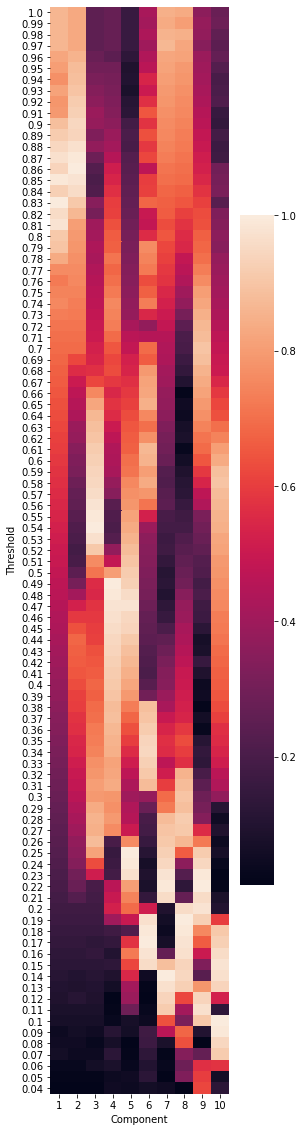

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
KWH.columns = np.arange(10)+1

plt.figure(figsize=(4,20))
fig = sns.heatmap(KWH.rank(pct=True)[::-1].astype(float), xticklabels=True, yticklabels=True)
fig.set(xlabel='Component', ylabel='Threshold')

The heatmap shows that at variance threshold at or lower than 0.2, the platform dependence of the first three PCs is adequately controlled.

### Gene filtering

In [61]:
genes = pd.DataFrame((vp.VarFraction<0.2).tolist(), columns=['inclusion'], index=vp.index)
print(len(vp.loc[vp.VarFraction<0.2]))
genes.to_csv('../data/interim/mouse_atlas/mouse_atlas_genes.tsv', sep='\t')

3779
